# Project 4 Machine Learning Fairness Algorithms Evaluation

Group 6: 
* Huang, Xilin (xh2508@columbia.edu)
* Nguyen, Kieu-Giang (kn2521@columbia.edu) 
* Spade, Gabriel (gms2221@columbia.edu) 
* Wang, Yayuan (yw3548@columbia.edu)
* Xu, Jiapeng (jx2427@columbia.edu)


## 1. Introduction

​​In this project, we are comparing two methodologies introduced by [A2-Maximizing accuracy under fairness constraints (C-SVM and C-LR)](https://arxiv.org/abs/1507.05259) and [A7-Information Theoretic Measures for Fairness-aware Feature selection (FFS)](https://arxiv.org/abs/2106.00772) to obtain a better understanding of the trade-off between accuracy and fairness. The criterion we use to quantify fairness is calibration, meaning that the prediction accuracy of the protected group ought to be equal to the accuracy of the unprotected group. 

We examine all the algorithms on [COMPAS Dataset](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis) to evaluate their performance. COMPAS dataset contains criminal history and demographic information. In this case, the race of each individual is our protected/sensitive attribute (African-American=0, Caucasian = 1). The binary target label (y) we are interested in is whether the individual was arrested for a crime within 2 years of release. 


In summary, according to the *A7-Information Theoretic Measures for Fairness-aware Feature Selection*, we select and encode our variables as follows: 

- Binary class label (y): <code>two_year_recid</code>, indicating whether the individual was arrested for a crime within 2 years of release
- Binary sensitive attribute: <code>race</code>, African-American=0, Caucasian = 1
- Other features: 
    *  <code>sex</code>: female = 0, male = 1
    *  <code>age</code>: less than 25 = 0, age 25~45 = 1, age older than 45 = 2
    *  <code>c_charge_degree</code>: misdemeanor = 0, felony = 1
    *  <code>priors_count</code>: none = 0, 1~3 times = 1, more than 3 = 2
    *  <code>length_of_stay</code>: normalized time elapsed from in jail until out of jail


## 2. Preparation
### 2.1 Data Cleansing and Processing

In [70]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [2]:
df_raw = pd.read_csv('../data/compas-scores-two-years.csv')    # load the data

In [3]:
length_of_stay = pd.to_datetime(df_raw["c_jail_out"]) - pd.to_datetime(df_raw["c_jail_in"])    # calculate length of stay (days)
df = df_raw
df["length_of_stay"] = length_of_stay.astype('timedelta64[h]')/24
df = df[["two_year_recid","race","sex","age","c_charge_degree","priors_count","length_of_stay"]]   # select features we are interested in
df = df.dropna()         # drop NA
df = df.loc[(df["length_of_stay"] > 0) &                                         # length of stay should be positive
       ((df["race"]== "African-American") | (df["race"]== "Caucasian"))]         # individuals who are African american or Caucasian
df.head()

,two_year_recid,race,sex,age,c_charge_degree,priors_count,length_of_stay
1,1,African-American,Male,34,F,0,10.041667
2,1,African-American,Male,24,F,4,1.083333
6,1,Caucasian,Male,41,F,14,6.291667
8,0,Caucasian,Female,39,M,0,2.916667
9,1,Caucasian,Male,21,F,1,0.958333


In [4]:
# encode features
df['race'] = df['race'].apply(lambda race: 0 if race == 'African-American' else 1)
df['sex'] = df['sex'].apply(lambda sex: 0 if sex == 'Female' else 1)
df['age'] = df['age'].apply(lambda age: 0 if age < 25 else (2 if age > 45 else 1))
df['c_charge_degree'] = df['c_charge_degree'].apply(lambda c_charge_degree: 0 if c_charge_degree == 'M' else 1)
df['priors_count'] = df['priors_count'].apply(lambda priors_count: 0 if priors_count == 0 else (2 if priors_count > 3 else 1))
df['length_of_stay'] = (df['length_of_stay'] - df['length_of_stay'].mean())/df['length_of_stay'].std()     # normalized the length of stay
df.head()

,two_year_recid,race,sex,age,c_charge_degree,priors_count,length_of_stay
1,1,0,1,1,1,0,-0.187151
2,1,0,1,0,1,2,-0.356541
6,1,1,1,1,1,2,-0.258059
8,0,1,0,1,0,0,-0.321875
9,1,1,1,0,1,1,-0.358905


### 2.1 Training and Test Sets

In [5]:
df_shuffled = df.sample(frac=1, random_state=1)      # shuffled the dataset
i = int(len(df_shuffled) * 0.7)         # use 70% as training set
train = df_shuffled[:i]                 # training set
test = df_shuffled[i:]                  # test set

label = "two_year_recid"
sensitive = "race"
features = ["sex","age","c_charge_degree","priors_count","length_of_stay"]

In [6]:
x_train, y_train, race_train = train[features], train[label].to_numpy(), train[sensitive]
x_test, y_test, race_test = test[features], test[label].to_numpy(), test[sensitive]

## 3. Baseline (Without Constraints)
### 3.1 Logistic Regression

Before fitting the logistic regression, let’s first define the function to calculate calibration(%) which could be understood as accuracy difference between two race groups.

In [7]:
# define the function for calculating calibration
def MyCalibration(sensitive_attr, y_pred, y_true):
    cau_index = np.where(sensitive_attr == 1)[0]           # index for Caucasians
    african_index = np.where(sensitive_attr == 0)[0]       # index for African-Americans
    
    y_pred_cau = y_pred[cau_index]           # Caucasians
    y_true_cau = y_true[cau_index] 
    Acc_cau = sum(y_pred_cau == y_true_cau)/len(y_pred_cau)

    y_pred_african = y_pred[african_index]   # African-Americans
    y_true_african = y_true[african_index]
    Acc_african = sum(y_pred_african == y_true_african)/len(y_pred_african)

    calibration = (Acc_cau - Acc_african)*100
    return(calibration)

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
logReg = LogisticRegression(random_state = 0).fit(x_train, y_train)   # logistic regression without constraints

In [10]:
summary_logReg = {"Methods": ["LR", "LR"], 
              "Set": ["Train", "Test"],
              "Accuracy (%)": [logReg.score(x_train, y_train)*100, logReg.score(x_test, y_test)*100],
              "Calibration(%)": [MyCalibration(race_train, logReg.predict(x_train), y_train),
                                 MyCalibration(race_test, logReg.predict(x_test), y_test)]}

pd.DataFrame(summary_logReg)

,Methods,Set,Accuracy (%),Calibration(%)
0,LR,Train,66.307345,0.016413
1,LR,Test,66.257310,0.502892


### 3.2 Support Vector Machine (SVM) 

In [11]:
from sklearn.svm import SVC

In [12]:
svm_model = SVC(kernel = 'linear', probability = True)
svm_model = svm_model.fit(x_train, y_train)

In [13]:
summary_svm = {"Methods": ["SVM", "SVM"], 
              "Set": ["Train", "Test"],
              "Accuracy (%)": [svm_model.score(x_train, y_train)*100, svm_model.score(x_test, y_test)*100],
              "Calibration(%)": [MyCalibration(race_train, svm_model.predict(x_train), y_train),
                                 MyCalibration(race_test, svm_model.predict(x_test), y_test)]}

pd.DataFrame(summary_svm)

,Methods,Set,Accuracy (%),Calibration(%)
0,SVM,Train,66.006518,0.731009
1,SVM,Test,64.561404,-0.431792


## 4. Implementation of Method 1 (A2)

<code>(Brief introduction about the algorithm)</code>

### 4.1 Logistic Regression With Fairness Constraints

In [ ]:
# code

### 4.2 Support Vector Machine (SVM) With Fairness Constraints

In [71]:
#modify the parameter in SVC function to optimize the accuracy under the fairness constraints
#The value of C in SVC function is the regularization parameter.
#Gamma value strongly affect the accuracy, to ensure our accuracy, we need to set it at a low value
#Instead of using linear kernel to classify the data, rbf (Gaussian Kernel Radial Basis Function) helps more.
C_SVM = SVC(C = 10, kernel = 'rbf', probability = True, gamma = 1)
c_svm_model = C_SVM.fit(x_train, y_train)

In [72]:
summary_c_svm = {"Methods": ["C-SVM", "C-SVM"], 
              "Set": ["Train", "Test"],
              "Accuracy (%)": [c_svm_model.score(x_train, y_train)*100, c_svm_model.score(x_test, y_test)*100],
              "Calibration(%)": [MyCalibration(race_train, c_svm_model.predict(x_train), y_train),
                                 MyCalibration(race_test, c_svm_model.predict(x_test), y_test)]}

pd.DataFrame(summary_c_svm)

,Methods,Set,Accuracy (%),Calibration(%)
0,C-SVM,Train,67.936826,0.596922
1,C-SVM,Test,65.847953,-0.062880


## 5. Implementation of Method 2 (A7)

<code>(Brief introduction about the algorithm)</code>

In [60]:
# Function to compute protect/non_protect ratio
def protect_ratio(sensitive_attr, y_pred):
    protect = np.where(sensitive_attr == 1)[0]
    non_protect = np.where(sensitive_attr == 0)[0]
    
    protect_pred = np.where(y_pred[protect] == 1)
    non_protect_pred = np.where(y_pred[non_protect] == 1)
    
    protect_prop = protect_pred[0].shape[0]/protect.shape[0]
    non_protect_prop = non_protect_pred[0].shape[0]/non_protect.shape[0]
    
    ratio = min(protect_prop/non_protect_prop, non_protect_prop/protect_prop)
    return ratio, protect_prop, non_protect_prop

### 5.1 Logistic Regression After Features Selection

In [22]:
# code
import shap

X = pd.concat([x_train, x_test], ignore_index=True)

explainer = shap.Explainer(logReg,X)
shap_values = explainer(X)

   sex  age  c_charge_degree  priors_count  length_of_stay
0    1    1                0             2       -0.183212
1    1    0                1             0       -0.359692
2    0    1                0             0       -0.364420
3    1    1                1             2        0.855976
4    1    1                1             2       -0.359692


In [23]:
print(shap_values.shape)
print(shap_values.shape == X.shape)
print(type(shap_values)) 

(5699, 5)
True
<class 'shap._explanation.Explanation'>


In [24]:
print(shap_values[1])

.values =
array([ 0.07755512,  0.75082301,  0.03756874, -0.74687142, -0.04864592])

.base_values =
-0.3037321139212805

.data =
array([ 1.        ,  0.        ,  1.        ,  0.        , -0.35969248])


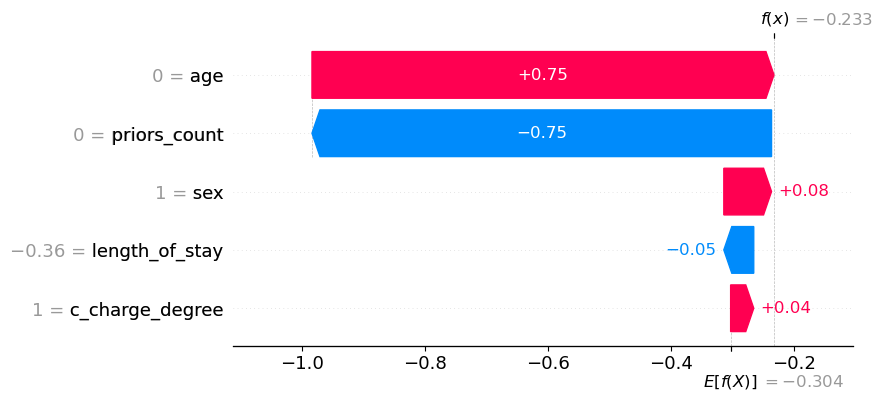

In [25]:
shap.plots.waterfall(shap_values[1])

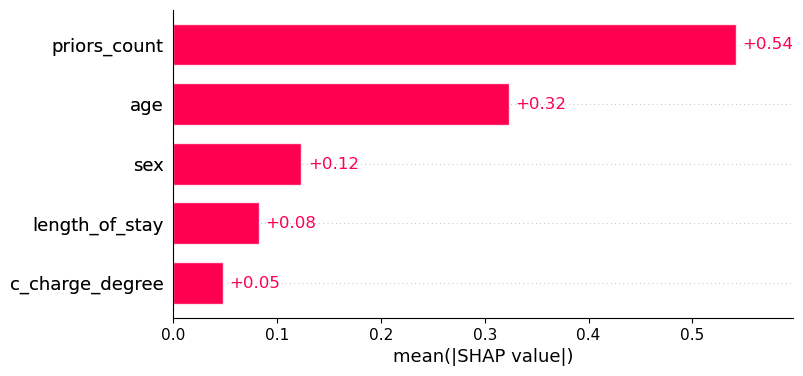

In [26]:
shap.plots.bar(shap_values)

In [61]:
clf = LogisticRegression(random_state = 0).fit(x_train, y_train)
coeff = clf.coef_
intercept = clf.intercept_
results_lr_ffs = {"Classifier": ["LR-FFS", "LR-FFS"],
                  "Set": ["Train", "Test"],
                  "Accuracy (%)": [clf.score(x_train, y_train)*100, clf.score(x_test, y_test)*100],
                  "Ratio": [protect_ratio(race_train, clf.predict(x_train))[0], protect_ratio(race_test, clf.predict(x_test))[0]],
                  "Protected (%)": [protect_ratio(race_train, clf.predict(x_train))[1]*100, protect_ratio(race_test, clf.predict(x_test))[1]*100],
                  "Non-Protected (%)": [protect_ratio(race_train, clf.predict(x_train))[2]*100, protect_ratio(race_test, clf.predict(x_test))[2]*100],
                  "Calibration (%)": [MyCalibration(race_train, clf.predict(x_train), y_train), MyCalibration(race_test, clf.predict(x_test), y_test)]}
pd.DataFrame(results_lr_ffs)

,Classifier,Set,Accuracy (%),Ratio,Protected (%),Non-Protected (%),Calibration (%)
0,LR-FFS,Train,66.307345,0.584558,31.770512,54.349662,0.016413
1,LR-FFS,Test,66.257310,0.601043,30.711044,51.096282,0.502892


### 5.2 Support Vector Machine (SVM) After Features Selection

In [62]:
# code
svm_model = SVC(kernel = 'linear', probability = True)
clf = svm_model.fit(x_train, y_train)
results_svm_ffs = {"Classifier": ["SVM-FFS", "SVM-FFS"],
                   "Set": ["Train", "Test"],
                   "Accuracy (%)": [clf.score(x_train, y_train)*100, clf.score(x_test, y_test)*100],
                   "Ratio": [protect_ratio(race_train, clf.predict(x_train))[0], protect_ratio(race_test, clf.predict(x_test))[0]],
                   "Protected (%)": [protect_ratio(race_train, clf.predict(x_train))[1]*100, protect_ratio(race_test, clf.predict(x_test))[1]*100],
                   "Non-Protected (%)": [protect_ratio(race_train, clf.predict(x_train))[2]*100, protect_ratio(race_test, clf.predict(x_test))[2]*100],
                   "Calibration (%)": [MyCalibration(race_train, clf.predict(x_train), y_train), MyCalibration(race_test, clf.predict(x_test), y_test)]}
pd.DataFrame(results_svm_ffs)

,Classifier,Set,Accuracy (%),Ratio,Protected (%),Non-Protected (%),Calibration (%)
0,SVM-FFS,Train,66.006518,0.576543,28.315854,49.113176,0.731009
1,SVM-FFS,Test,64.561404,0.582566,26.323752,45.185891,-0.431792


## 6. Evaluation

In [34]:
# summary table for test results

# ------please add test set results to the following table-------

summary_total = {"Methods": ["LR", "SVM"], 
              "Accuracy (%)": [logReg.score(x_test, y_test)*100, svm_model.score(x_test, y_test)*100],
              "Calibration(%)": [MyCalibration(race_test, logReg.predict(x_test), y_test),
                                 MyCalibration(race_test, svm_model.predict(x_test), y_test)]}
pd.DataFrame(summary_total)    


,Methods,Accuracy (%),Calibration(%)
0,LR,66.257310,0.502892
1,SVM,64.561404,-0.431792


<code>summary & conclusion</code>